## Week 3

**Using a simple RNN or LSTM**

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# helper to generate dummy data

def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

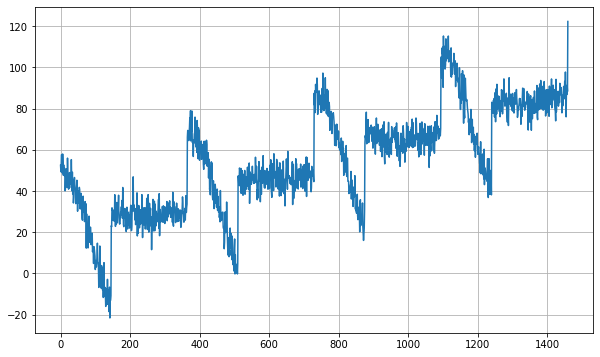

In [114]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

In [115]:
# get the train and test set
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

In [116]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000


def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [117]:
# generates the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


# print features and labels
for window in dataset.take(1):
  print(f'shape of feature: {window[0].shape}')
  print(f'shape of label: {window[1].shape}')

shape of feature: (32, 20)
shape of label: (32,)


In [ ]:
# since our data is shape (batch, window or time_step) i.e 32, 20 and RNN req shape (batch, time_step, input_dim)
# we need to reshape data to this to give (32, 20, 1). can be done before passing data to model or can be done in a layer which is Lambda layer. cool stuff
# we scale dense by using lambda to multiply to 100.0 since RNN using tanh activation which squishes output to range -1, 1 so output will have similar scale as 
# our labels, else our prediction will seem incorrect even though they aren't

# Using Simple RNN
# model_base = keras.models.Sequential([
#     keras.layers.Lambda(
#         lambda x: tf.expand_dims(x, axis = -1), # tp get 32, 20, 1
#         input_shape = [window_size] # can be set to None to have flexibility in timesteps
#     ),
#     keras.layers.SimpleRNN(40, return_sequences=True),
#     keras.layers.SimpleRNN(40),
#     keras.layers.Dense(1),
#     keras.layers.Lambda(lambda x: x * 100.0)  # scales x to match our label

# ])


# Using LSTM
model_base = keras.models.Sequential([
    keras.layers.Lambda(
        lambda x: tf.expand_dims(x, axis = -1), 
        input_shape = [window_size] 
    ),
    keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(32)),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 100.0)  

])


model_base.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_16 (Lambda)          (None, 20, 1)             0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 20, 64)           8704      
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
 lambda_17 (Lambda)          (None, 1)                 0         
                                                                 
Total params: 33,601
Trainable params: 33,601
Non-trai

In [ ]:
# tuning the learning rate
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**((epoch / 20))
)

optimizer = keras.optimizers.SGD(momentum = 0.9)

model_base.compile(loss = keras.losses.Huber(), optimizer=optimizer)

history = model_base.fit(dataset, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
31/31 [==============================] - 5s 10ms/step - loss: 62.2596 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 10ms/step - loss: 61.6963 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 61.0082 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 60.2286 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 59.3433 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 9ms/step - loss: 58.3325 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 9ms/step - loss: 57.1710 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 9ms/step - loss: 55.8197 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 9ms/step - loss: 54.2273 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 10ms/step - loss: 52.2994 - lr: 2.8184e-08
Epoch 11/100
31/

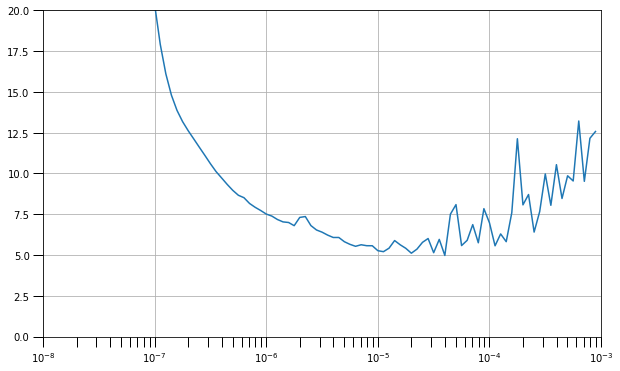

In [ ]:
# helper to plot learning rate to loss
def plot_loss_to_lr(history, zoom_in = False):

  lrs = 1e-8 * (10 ** (np.arange(100) / 20))

  # Set the figure size
  plt.figure(figsize=(10, 6))

  # Set the grid
  plt.grid(True)

  # Plot the loss in log scale
  plt.semilogx(lrs, history.history["loss"])

  # Increase the tickmarks size
  plt.tick_params('both', length=10, width=1, which='both')

  if zoom_in == True:
    # Set the plot boundaries
    plt.axis([1e-8, 1e-3, 0, 20])
  else: 
    plt.axis([1e-8, 1e-3, 0, 50])

  plt.show();
  


plot_loss_to_lr(history, True)



In [ ]:
# train model with new lr

# Using RNN
# model_tune = keras.models.Sequential([
#     keras.layers.Lambda(
#         lambda x: tf.expand_dims(x, axis = -1), # tp get 32, 20, 1
#         input_shape = [window_size] # can be set to none to have flexibility in timesteps
#     ),
#     keras.layers.SimpleRNN(40, return_sequences=True),
#     keras.layers.SimpleRNN(40),
#     keras.layers.Dense(1),
#     keras.layers.Lambda(lambda x: x * 100.0)  # scales x to match our label
# ])


# Using LSTM
model_tune = keras.models.Sequential([
    keras.layers.Lambda(
        lambda x: tf.expand_dims(x, axis = -1), 
        input_shape = [window_size] 
    ),
    keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(32)),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 100.0)  

])

# model_tune.summary()

# Set the learning rate
learning_rate = 7e-6 # gotten after inspecting graph

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model_tune.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 6s 10ms/step - loss: 35.8342 - mae: 36.3296
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 12.1637 - mae: 12.6550
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 8.0914 - mae: 8.5736
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 6.6723 - mae: 7.1552
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 6.3216 - mae: 6.8034
Epoch 6/100
31/31 [==============================] - 0s 10ms/step - loss: 6.0625 - mae: 6.5397
Epoch 7/100
31/31 [==============================] - 0s 10ms/step - loss: 5.7157 - mae: 6.1924
Epoch 8/100
31/31 [==============================] - 0s 10ms/step - loss: 5.5906 - mae: 6.0650
Epoch 9/100
31/31 [==============================] - 0s 9ms/step - loss: 5.5017 - mae: 5.9819
Epoch 10/100
31/31 [==============================] - 0s 10ms/step - loss: 5.5251 - mae: 6.0028
Epoch 11/100
31/31 [=============================

In [4]:
# making predictions using by processing batch of windows rather than iterating over one window at a time using for loops
# this is faster than previous implementations using a tf dataset

def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)  # we don't shuffle, since we want right sequence to compare data to val data
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

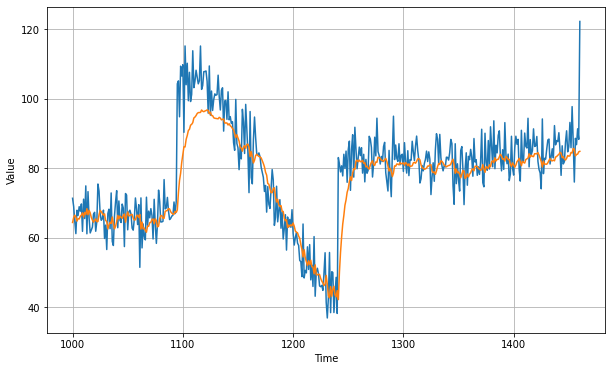

61.12161
5.5502634


In [ ]:
# Reduce the original series
forecast_series = series[split_time - window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model_tune, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

In [ ]:
# including validation_set while training model

# gen data windows of the validation set


# Reset states generated by Keras
keras.backend.clear_session()
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

# LSTM
model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),  # allows for flexible window_size by setting input shape as None
  keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 7e-6

# Set the optimizer ( could use Adam optimizer too to get better result)
optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100, validation_data=val_set)

Epoch 1/100
31/31 [==============================] - 8s 60ms/step - loss: 24.1363 - mae: 24.6325 - val_loss: 28.6007 - val_mae: 29.0986
Epoch 2/100
31/31 [==============================] - 1s 14ms/step - loss: 9.0464 - mae: 9.5341 - val_loss: 14.9798 - val_mae: 15.4761
Epoch 3/100
31/31 [==============================] - 1s 14ms/step - loss: 7.2339 - mae: 7.7183 - val_loss: 11.7525 - val_mae: 12.2376
Epoch 4/100
31/31 [==============================] - 1s 14ms/step - loss: 6.3851 - mae: 6.8641 - val_loss: 10.6077 - val_mae: 11.1004
Epoch 5/100
31/31 [==============================] - 1s 14ms/step - loss: 6.0472 - mae: 6.5242 - val_loss: 8.2545 - val_mae: 8.7413
Epoch 6/100
31/31 [==============================] - 1s 14ms/step - loss: 5.6906 - mae: 6.1679 - val_loss: 6.9053 - val_mae: 7.3894
Epoch 7/100
31/31 [==============================] - 1s 14ms/step - loss: 5.7167 - mae: 6.1969 - val_loss: 6.6606 - val_mae: 7.1411
Epoch 8/100
31/31 [==============================] - 1s 14ms/step 

## Week 4

In [118]:
# extra feature added to the previously created plot_series function
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [119]:
# using same old synthetic dataset from above but with new parameters
window_size = 20
batch_size = 16
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

Here is the model architecture you will be using. It is very similar to the last RNN you built but with the [Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) layer at the input. One important [argument](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D#args) here is the `padding`. For time series data, it is good practice to not let computations for a particular time step to be affected by values into the future. Here is one way of looking at it:

* Let's say you have a small time series window with these values: `[1, 2, 3, 4, 5]`. This means the value `1` is at `t=0`, `2` is at `t=1`, etc.
* If you have a 1D kernel of size `3`, then the first convolution will be for the values at `[1, 2, 3]` which are values for `t=0` to `t=2`.
* When you pass this to the first timestep of the `LSTM` after the convolution, it means that the value at `t=0` of the LSTM depends on `t=1` and `t=2` which are values into the future.
* For time series data, you want computations to only rely on current and previous time steps.
* One way to do that is to pad the array depending on the kernel size and stride. For a kernel size of 3 and stride of 1, the window can be padded as such: `[0, 0, 1, 2, 3, 4, 5]`. `1` is still at `t=0` and two zeroes are prepended to simulate values in the past.
* This way, the first stride will be at `[0, 0, 1]` and this does not contain any future values when it is passed on to subsequent layers.

The `Conv1D` layer does this kind of padding by setting `padding=causal` and you'll see that below.

In [126]:
tf.keras.backend.clear_session()

# Build Model
model = keras.models.Sequential([
    keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1,
                        padding ="causal", activation ="relu",
                        input_shape = [window_size, 1]), # time step and input dim
    keras.layers.LSTM(64, return_sequences = True),
    keras.layers.LSTM(64),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 100)  # check scaling this to 100 and not 400
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 20, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 66,369
Trainable params: 66,369
Non-trainable params: 0
_________________________________________________________________


In [127]:
# previously we were using different models for tuning and training. but now we can use the same model for both following below

# Get initial weights before training
init_weights= model.get_weights()


# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule], verbose = 0)

(1e-08, 0.001, 0.0, 50.0)

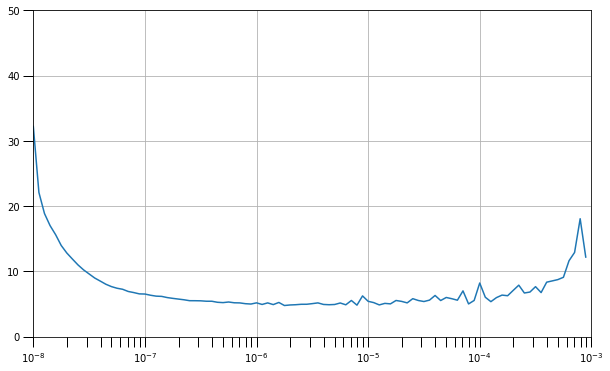

In [128]:
# to plot loss to lR as before
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

In [129]:
# set learned weights of model to now be the weights before training
# so we can use this model and retrain again to see result

keras.backend.clear_session()

# Resets the weight to this and train model again with the  new learning rate
model.set_weights(init_weights)

learning_rate= 9e-7
optimizer = keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9)
model.compile(loss = keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])
history = model.fit(train_set, epochs = 500, verbose = 0)

Training can be a bit unstable especially as the weights start to converge so you may want to visualize it to see if it is still trending down. The earlier epochs might dominate the graph so it's also good to zoom in on the later parts of training to properly observe the parameters. The code below visualizes the `mae` and `loss` for all epochs, and also zooms in at the last 80%.

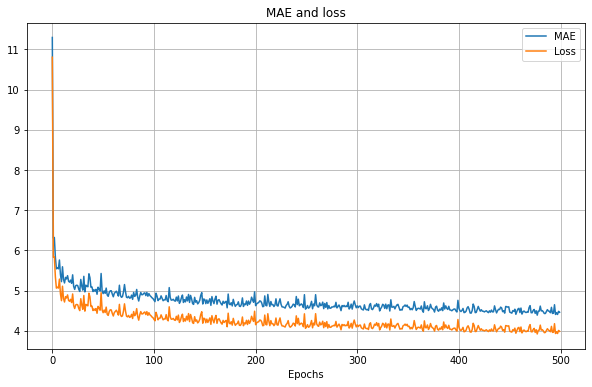

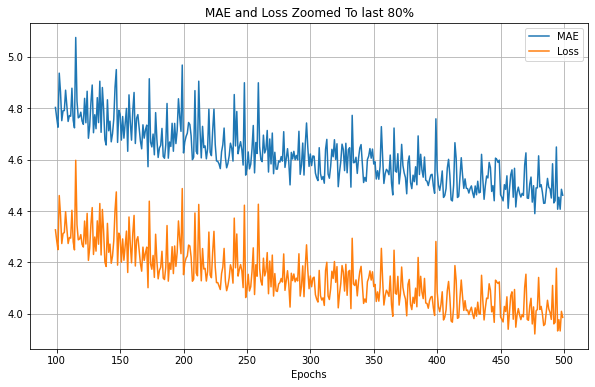

In [131]:
mae = history.history["mae"]
loss = history.history["loss"]

epochs = range(len(loss))

plot_series(
    x = epochs,
    y = (mae, loss),
    title = "MAE and loss",
    xlabel = "Epochs",
    legend = ["MAE", "Loss"]
)

# only plot the last 80% of the epochs
# since last 80% multiply the number at last index by remiainig i.e 20%
# since epochs is a list of numbers in ascending order with step of 1, this will work
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss Zoomed To last 80%', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

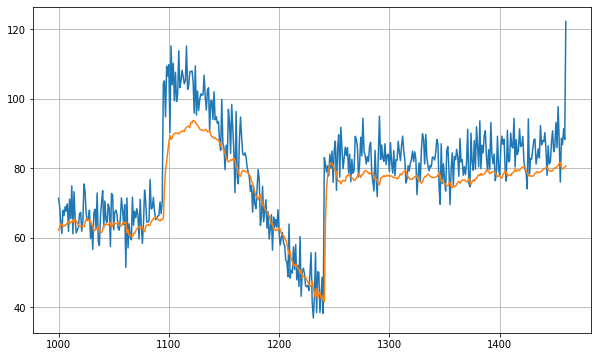

75.14324
6.5563164


In [132]:
forecast_series = series[split_time - window_size: -1]

forecast = model_forecast(model, forecast_series, window_size, batch_size)

# convert forecasts to 1D array
results = forecast.squeeze()

plot_series(time_valid, (x_valid, results))

print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())


Required val MAE of < 5.2 is met, so cancelling training!


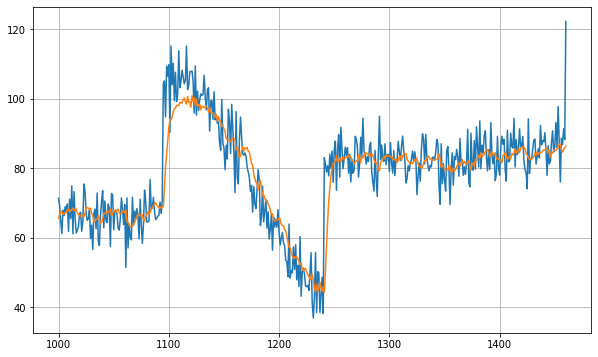

49.65841
5.0974946


In [133]:
# Training with EarlyStopping Callback

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get("val_mae") != None and logs.get("val_mae") < 5.2):
      print("\nRequired val MAE of < 5.2 is met, so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()      

# gen val set
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

# set weights to untrained_weights
model.set_weights(init_weights)


learning_rate = 9e-7

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=500,
                    validation_data=val_set, callbacks=[callbacks],
                    verbose = 0)


# Predictions( should have used a seperate test set in practice, but since data is already too small, we just used the val set as our test_set)
forecast_series = series[split_time - window_size: -1]
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# convert forecasts to 1D array
results = forecast.squeeze()

plot_series(time_valid, (x_valid, results))

"""
  For this computed metrics will be different from the trainin output, we though it's still x_valid
  since it has more points to evaluate. having points from t=1000 to t=1460 i.e the predictions
  but val_set(windowed dataset from x_valid) has just 441 points since predictions start from t-1020 
  since t=1000 to t=1019 is where windowing starts, could do same thing to val set to help match with this
  i.e series[split_time - window_size: -1] and then pass this to the window function for getting val set

"""
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

**Predicting on Real Time Series Data(SunSpot Data)**

In [61]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import csv
import matplotlib.pyplot as plt

# Download the dataset(could also have download this from kaggle)
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

# similar to pandas head function(each data point is a month so window size of 24 is window_size of 2 years)
!head Sunspots.csv

--2022-09-29 13:19:41--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 74.125.200.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0s      

2022-09-29 13:19:41 (160 MB/s) - ‘Sunspots.csv’ saved [70827/70827]

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
5,1749-06-30,139.2
6,1749-07-31,158.0
7,1749-08-31,110.5
8,1749-09-30,126.5


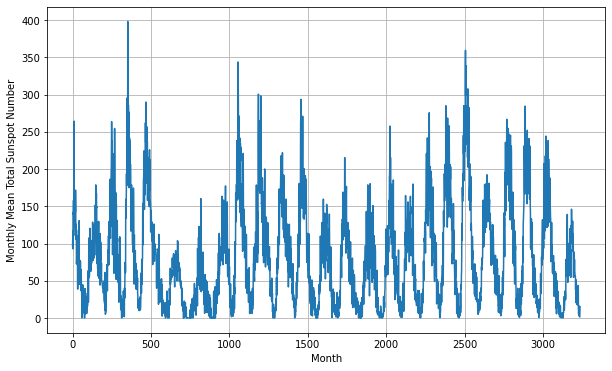

In [137]:
time_step = []
sunspots = []

# Open CVS file
with open("./Sunspots.csv") as csvfile:
  reader = csv.reader(csvfile, delimiter = ",")

  # skips first reader line since it's the headers
  next(reader)

  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))


time = np.array(time_step)
series = np.array(sunspots)

# preview data
plot_series(time, series, xlabel='Month', ylabel = "Monthly Mean Total Sunspot Number")

In [144]:
split_time = 3000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

# params(could be tweaked to get better result)

# 2.5 years since each point in time is a month
# could use smaller window to get better result like 2 years
window_size = 24 

batch_size = 32
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [180]:
# Build the model
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
#     tf.keras.layers.Dense(10, activation="relu"),
#     tf.keras.layers.Dense(1)
# ])

# using a complex model(if doesn't give better result, make model simpler)
model = keras.models.Sequential([
    keras.layers.Conv1D(filters = 64, kernel_size = 3,
                        strides = 1, activation ="relu",
                        padding ="causal",
                        input_shape = [window_size, 1]),
    keras.layers.LSTM(64, return_sequences = True),
    keras.layers.LSTM(64),

    # Don't use Bidirectional LSTM for time series data, since in reality we can't get future series at t+n to help in our predictions
    # best to use LSTM, hope I'm not wrong
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    keras.layers.Dense(30, activation ="relu"),
    keras.layers.Dense(10, activation ="relu"),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 100)
])

init_weights = model.get_weights()

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 24, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 24, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

In [172]:
learning_rate = 2e-5

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,epochs=100, verbose = 0, callbacks = [lr_schedule])

(1e-08, 0.001, 0.0, 100.0)

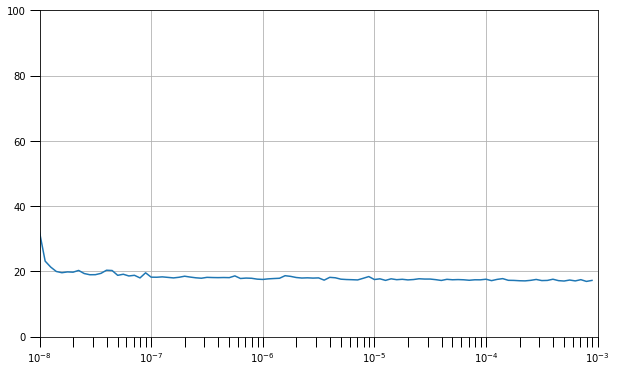

In [175]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))


plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

In [181]:
# train model with optimial lr
keras.backend.clear_session()

model.set_weights(init_weights)

learning_rate = 2e-6
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100, verbose = 0)

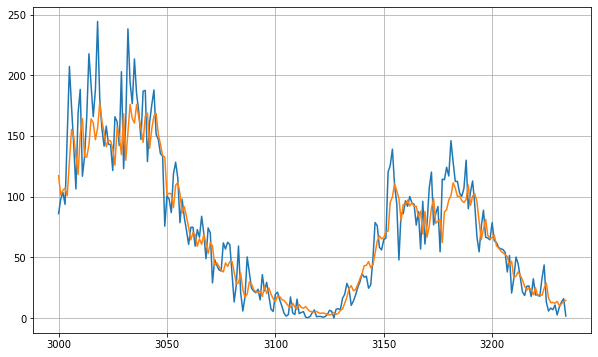

14.303173


In [182]:
# predictions
forecast_series = series[split_time - window_size: -1]
forecast = model_forecast(model, forecast_series, window_size, batch_size)
results = forecast.squeeze()

plot_series(time_valid, (x_valid, results))
print(keras.metrics.mean_absolute_error(x_valid, results).numpy())

**Another way to setting learing rate dynamically**

Since with static learning training for a long time generates less and less changes to the loss or metrics.
To see continous model improvement we could decrease the learning rate after X amount of epochs.
You can pass in a lambda function similar like the one you did for the learning rate scheduler earlier, or use ExponentialDecay(). This is a built in scheduler from the Keras API. This decays the learning rate defined by this function:
```python
def decayed_learning_rate(step):
  return initial_learning_rate * decay_rate ^ (step / decay_steps)
```

In [183]:
# initial learning_rate
initial_learning_rate = 2e-6

# Define the learning rate schduler
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps = 400,
    decay_rate = 0.96,
    staircase=True
)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

model.set_weights(init_weights)
# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=40)

Epoch 1/40
93/93 [==============================] - 4s 15ms/step - loss: 64.2471 - mae: 64.7452
Epoch 2/40
93/93 [==============================] - 2s 16ms/step - loss: 44.6726 - mae: 45.1700
Epoch 3/40
93/93 [==============================] - 2s 13ms/step - loss: 35.4017 - mae: 35.8973
Epoch 4/40
93/93 [==============================] - 1s 9ms/step - loss: 30.3035 - mae: 30.7982
Epoch 5/40
93/93 [==============================] - 1s 9ms/step - loss: 26.8809 - mae: 27.3754
Epoch 6/40
93/93 [==============================] - 1s 9ms/step - loss: 24.3152 - mae: 24.8091
Epoch 7/40
93/93 [==============================] - 1s 9ms/step - loss: 23.4722 - mae: 23.9673
Epoch 8/40
93/93 [==============================] - 1s 9ms/step - loss: 21.3744 - mae: 21.8674
Epoch 9/40
93/93 [==============================] - 1s 9ms/step - loss: 21.6052 - mae: 22.0990
Epoch 10/40
93/93 [==============================] - 1s 9ms/step - loss: 21.0853 - mae: 21.5800
Epoch 11/40
93/93 [===========================

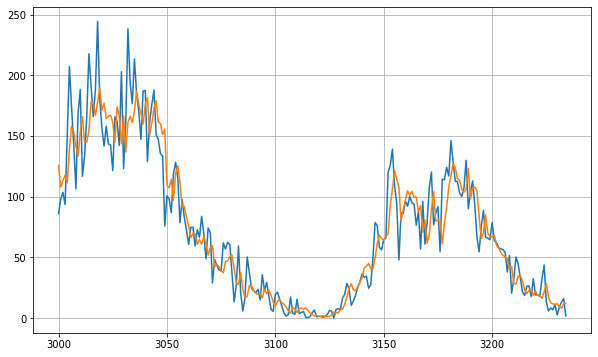

14.821883


In [184]:
# predictions
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())